# Animal Classification - An exploration of CNN models

In [ ]:
import kagglehub
import os
import shutil
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.models import load_model

First we start of with importing the code...

In [ ]:
# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


# 1. Checking dataset contents

In [ ]:
print("Dataset contents:", os.listdir("/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2"))

Dataset contents: ['translate.py', 'raw-img']


# 2. Renaming the italian names into english with a for loop

In [ ]:
# Define dataset path
dataset_dir = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"

# Italian-to-English class name mapping
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

# Loop through Italian folders and renaming them.
for italian_name, english_name in translate.items():
    old_folder = os.path.join(dataset_dir, italian_name)
    new_folder = os.path.join(dataset_dir, english_name)

    if os.path.exists(old_folder) and not os.path.exists(new_folder):
        shutil.move(old_folder, new_folder)
        print(f"Renamed: {italian_name} → {english_name}")
    elif os.path.exists(new_folder):
        print(f"Already renamed: {english_name}")
    else:
        print(f"Folder not found: {italian_name}")

print("Folder renaming completed")

Already renamed: dog
Already renamed: horse
Already renamed: elephant
Already renamed: butterfly
Already renamed: chicken
Already renamed: cat
Already renamed: cow
Already renamed: sheep
Already renamed: spider
Already renamed: squirrel
Folder renaming completed


# 3. Printing Class names for confirmation

In [ ]:
class_names = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
print("Updated class names:", class_names)

Updated class names: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


# 4. Checking folders and lists

In [ ]:
current_folders = sorted(os.listdir(dataset_dir))

print("Current folders:", current_folders)

Current folders: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


# 5. Checking for valid extensions

In [ ]:
valid_extensions = ['.jpg', '.jpeg', '.png']
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if any(f.endswith(ext) for ext in valid_extensions)]
        print(f"{class_name}: {len(images)} valid images")

sheep: 1820 valid images
spider: 4821 valid images
squirrel: 1862 valid images
cow: 1866 valid images
elephant: 1446 valid images
cat: 1668 valid images
dog: 4863 valid images
butterfly: 2112 valid images
chicken: 3098 valid images
horse: 2623 valid images


# 6. Resizing, keeping aspect ratio and selecting Target_Size

In [ ]:
# Define target size
TARGET_SIZE = (128, 128)

def resize_with_padding(image, target_size=TARGET_SIZE):
    h, w = image.shape[:2]

    # scaling
    scale = min(target_size[0] / w, target_size[1] / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # aspect ratio preserved resizing
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    canvas = np.ones((target_size[1], target_size[0], 3), dtype=np.uint8) * 255  # White background

    # padding
    y_offset = int((target_size[1] - new_h) / 2)
    x_offset = int((target_size[0] - new_w) / 2)

    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_image

    return canvas

def preprocess_dataset_with_padding(dataset_path, output_path):
    os.makedirs(output_path, exist_ok=True)

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        output_class_path = os.path.join(output_path, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                output_img_path = os.path.join(output_class_path, img_name)

                try:
                    image = cv2.imread(img_path)
                    if image is None:
                        continue

                    # Apply resizing with padding
                    processed_img = resize_with_padding(image)

                    # Save the processed image
                    cv2.imwrite(output_img_path, processed_img)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Define original and new dataset paths
dataset_path = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"
output_path = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10_padded"

# Preprocess images with padding
print("Preprocessing images...")
preprocess_dataset_with_padding(dataset_path, output_path)
print("Preprocessing complete. Padded images are saved at:", output_path)

Preprocessing images...
Preprocessing complete. Padded images are saved at: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10_padded


# 7. Processing results and comparison to original

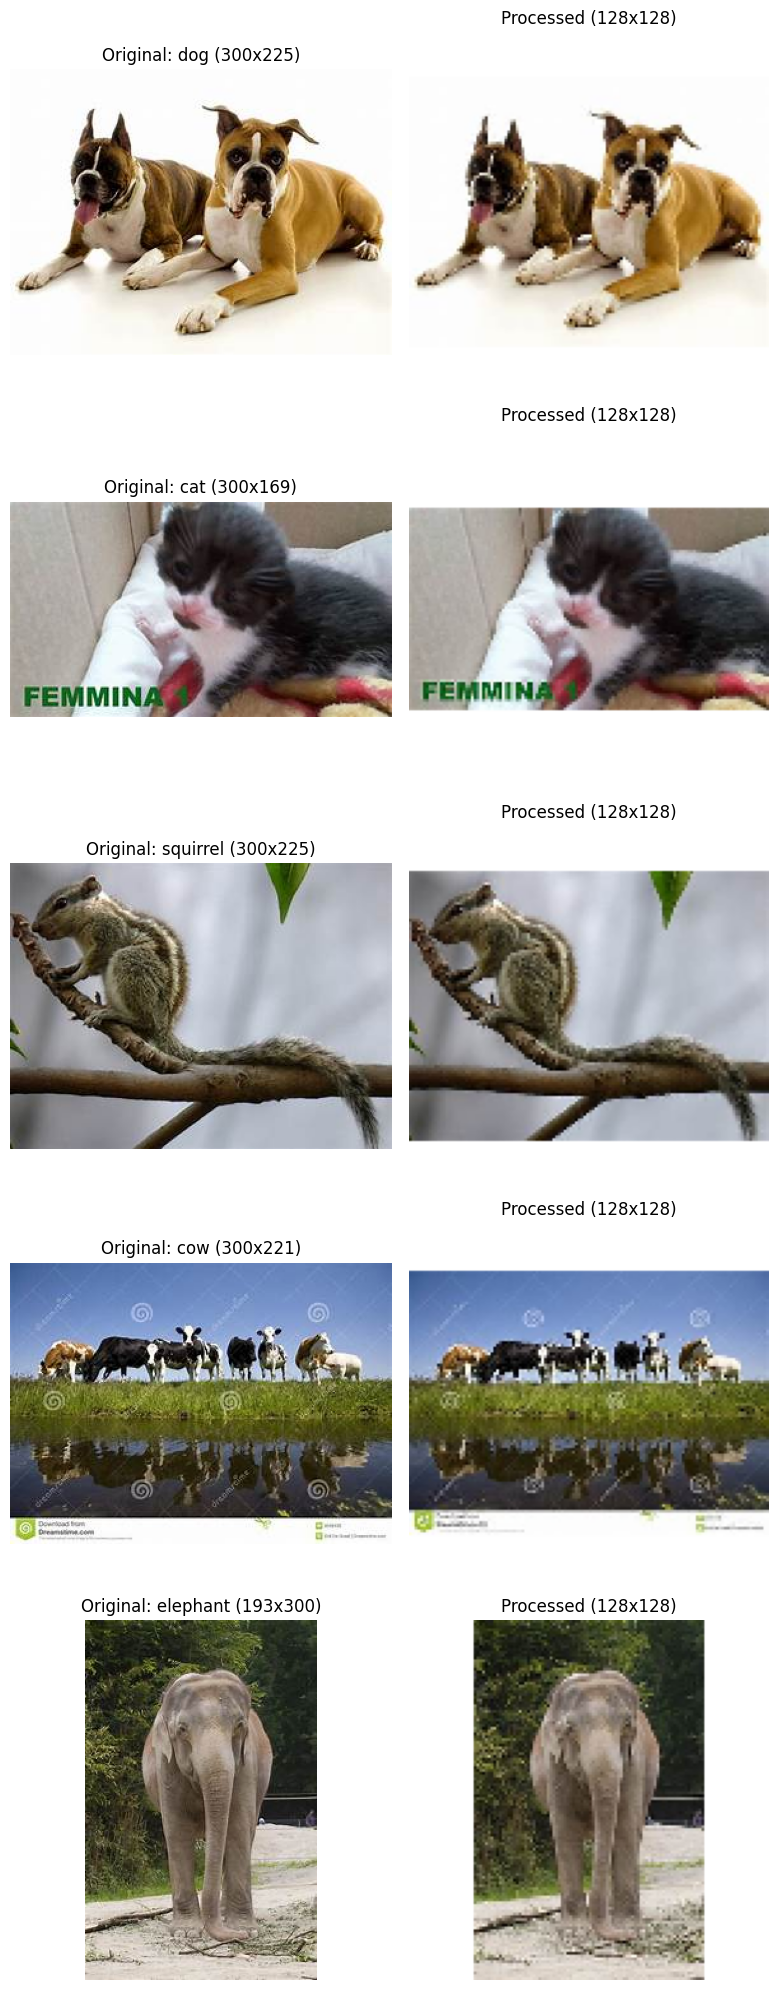

In [ ]:
# (original images)
dataset_path = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"

def get_random_images(dataset_path, num_samples=5):
    images = []
    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for class_dir in random.sample(class_dirs, min(num_samples, len(class_dirs))):  # Get random classes
        class_path = os.path.join(dataset_path, class_dir)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        if image_files:
            img_path = os.path.join(class_path, random.choice(image_files))
            images.append((img_path, class_dir))

    return images

sample_images = get_random_images(dataset_path)

# Plot original vs. resized images
fig, axes = plt.subplots(len(sample_images), 2, figsize=(8, 4 * len(sample_images)))

for i, (img_path, label) in enumerate(sample_images):
    # Read original image
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Apply resizing with padding
    processed_img = resize_with_padding(original_img)

    # Plot original image
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title(f"Original: {label} ({original_img.shape[1]}x{original_img.shape[0]})")
    axes[i, 0].axis("off")

    # Plot processed image
    axes[i, 1].imshow(processed_img)
    axes[i, 1].set_title(f"Processed (128x128)")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# 8. Data Preprocessing & Augmentation:

> Applies transformations (rotation, shift, shear, zoom, flip) to enhance generalization, rescales images to [0,1], and ensures consistent 128x128 input size with padding.




In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 9. Training Dataset

In [ ]:
train_dir = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10_padded"
batch_size = 32
img_size = (128, 128)

# Load datasets using tensorflow
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Optimize performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


# 9.5 Visualization of Training-dataset

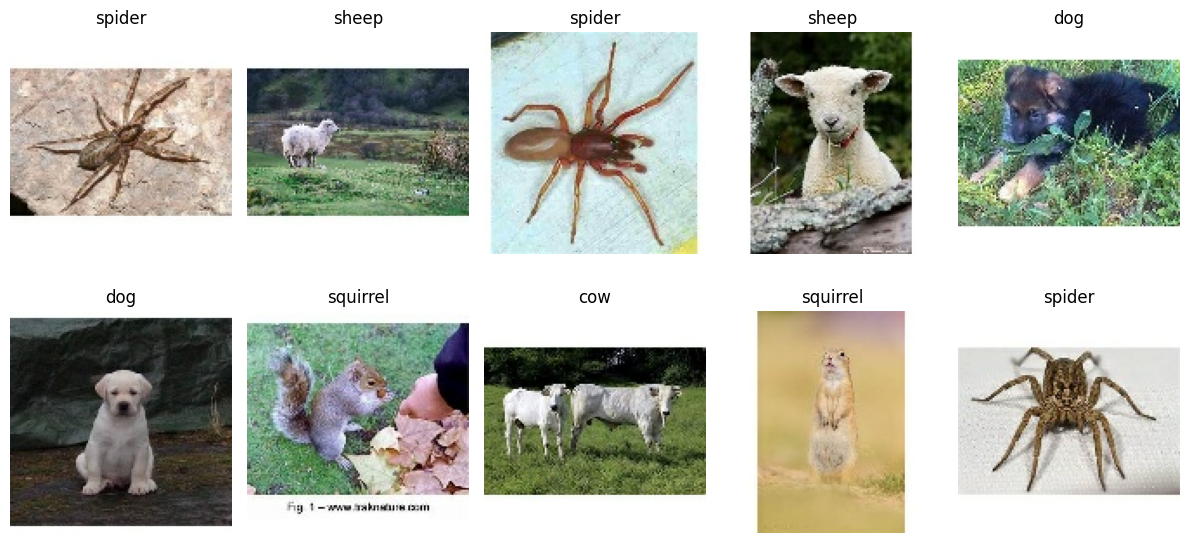

In [ ]:
num_images_to_show = 10

# Get a SINGLE BATCH of images and labels
images, labels = next(iter(train_dataset))

# Convert labels to NumPy and ensure 1D
labels = labels.numpy()
if labels.ndim > 1:
    labels = labels.flatten()

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(num_images_to_show):
    if i >= images.shape[0]:
        break

    image = images[i].numpy().astype(np.uint8)
    label = labels[i]

    axes[i].imshow(image)
    axes[i].set_title(class_names[label])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# 10. Visualization of data augmentations

In [ ]:

# Loading sample image to see the data augmentations in action
image_path = "/content/horses_2.jpg"
img = load_img(image_path, target_size=(128, 128))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  #

# Define the same ImageDataGenerator as used for training -
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest"
)

augmented_images = datagen.flow(img_array, batch_size=1)

# Plot augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    augmented_image = next(augmented_images)[0]
    augmented_image = np.clip(augmented_image, 0, 1)
    axes[i].imshow(augmented_image)
    axes[i].axis('off')

plt.suptitle("Augmented Images", fontsize=16)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/horses_2.jpg'

# 11. The Model

In [ ]:


model = models.Sequential([

    layers.Input(shape=(128, 128, 3)),

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)), #adjusted
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
# Show Model Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 5,901,258 (22.51 MB)

 Trainable params: 5,899,274 (22.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

# 12. Fitting the model and running it for 50 epochs with early stopping



> Also added "reduce_lr" which means it actively reduces learning rate when there is no improvement in val_acc



In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6) #reducing learning rate when there is no improvement

early_stopping = EarlyStopping(
    monitor='val_accuracy',     #checking for improvement of val_accuracy, as a low value suggest overfitting.
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.2150 - loss: 2.9048 - val_accuracy: 0.3032 - val_loss: 2.1732 - learning_rate: 0.0010
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3793 - loss: 1.8014 - val_accuracy: 0.4581 - val_loss: 1.5701 - learning_rate: 0.0010
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4694 - loss: 1.5417 - val_accuracy: 0.5165 - val_loss: 1.5336 - learning_rate: 0.0010
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5509 - loss: 1.3155 - val_accuracy: 0.5780 - val_loss: 1.2784 - learning_rate: 0.0010
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6262 - loss: 1.1265 - val_accuracy: 0.6176 - val_loss: 1.1272 - learning_rate: 0.0010
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6670 - loss: 0.9932 - val_accuracy: 0.6245 - val_loss: 1.1171 - learning_rate: 0.0010
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7203 - l

# 13. Plotting the Validation Accuracy and Validation Loss

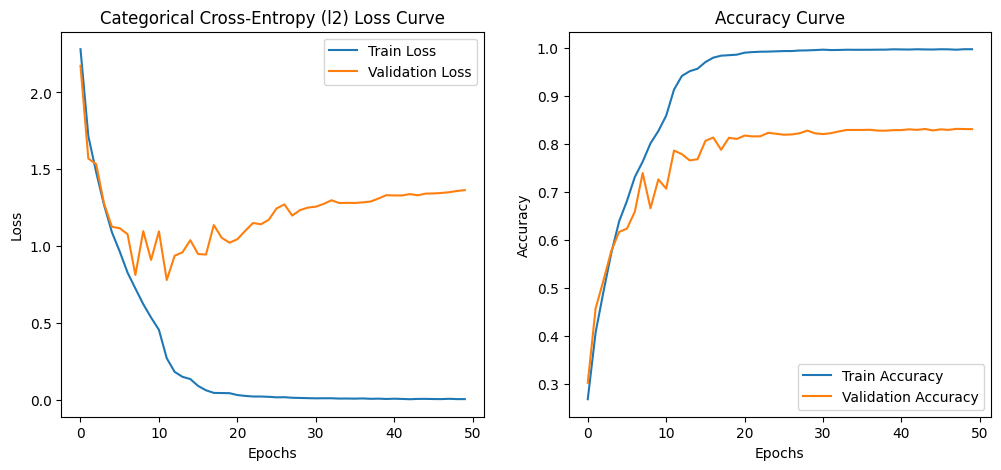

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Categorical Cross-Entropy (l2) Loss Curve')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

# 14. Using sklearn.metrics Classification report and plotting the Confusion Matrix and F1 score.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

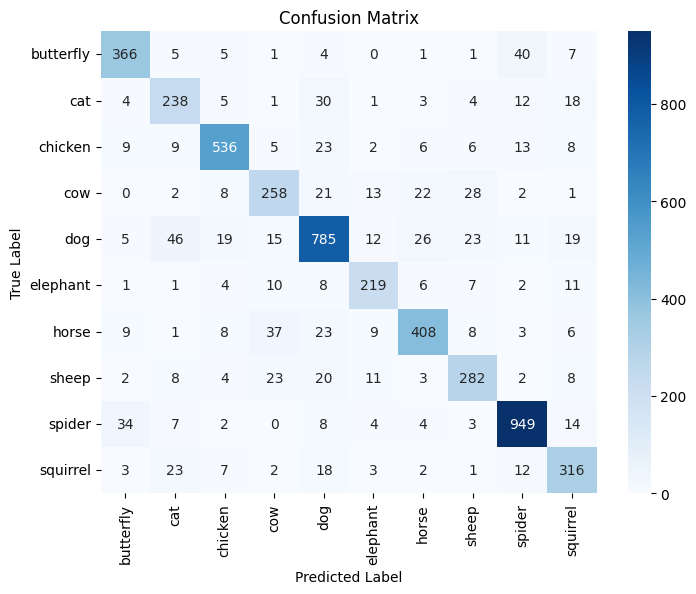

In [ ]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compute Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute F1-Score (Macro and Weighted)
macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

print(f"\nMacro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# ✅ Use manually defined class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



# 14.5 Most confused classes:

In [ ]:
def most_confused_pairs(y_true, y_pred, class_names, top_n=3):
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0)  # Remove correct predictions to focus on misclassifications

    # Get the top misclassifications
    confused_pairs = np.unravel_index(np.argsort(cm.ravel())[-top_n:], cm.shape)

    print("\nTop Confused Class Pairs:")
    for i in range(top_n):
        print(f"{class_names[confused_pairs[0][i]]} → {class_names[confused_pairs[1][i]]}: {cm[confused_pairs[0][i], confused_pairs[1][i]]} times")

# Example usage
most_confused_pairs(y_true, y_pred, class_names, top_n=5)



Top Confused Class Pairs:
cat → dog: 30 times
spider → butterfly: 34 times
horse → cow: 37 times
butterfly → spider: 40 times
dog → cat: 46 times


# 15. Saving the model - Alpha

In [ ]:
model.save("Alpha_3.keras")

# 15.5 Loading Model




In [ ]:
model = load_model("Alpha_3.keras")

# 16. Testing the predictions with our own Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
The given image is of class: 0 
Animal: butterfly


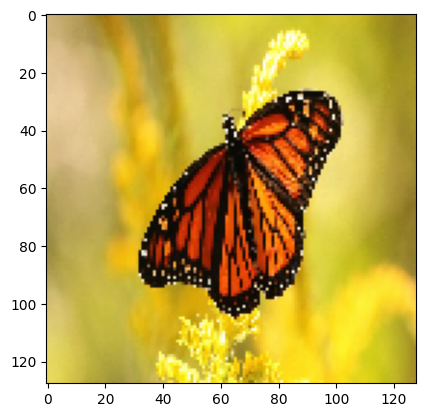

In [ ]:
import tensorflow as tf

def predictor(img, model):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Load image
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    plt.imshow(image)

    # preprocess image
    image = np.reshape(image, (1, 128, 128, 3))


    class_names = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant',
                   'horse', 'sheep', 'spider', 'squirrel']

    # Make predictions
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # Print result
    print(f"The given image is of class: {predicted_class_index} \nAnimal: {predicted_class_name}")

# Load the model
my_model = tf.keras.models.load_model("/content/Alpha_3.keras")

# Run prediction
predictor("/content/mariposa.jpg", my_model)


# The end